In [6]:
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('png')

%load_ext autoreload
%autoreload 2
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [26]:
models = {
#     "GloVe": "baseline",
#     "ConvS2S": "fairseq.wmt14.en-fr.fconv",
#     "InferSent": "infersent.allnli",
#     "IMDB": "imdbsentiment",
#     "skipthought": "skipthought",
#     "DisSent": "dissent.books8.epoch9",
#     "order": "order-embeddings",
#     "ELMo": "elmo.2x4096",
#     "BERT": "bert.base",
# #     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-MRPC",
#     "BERT-CoLA": "bert.base.finetune-CoLA",
#     "BERT-MNLI": "bert.base.finetune-MNLI",
#     "BERT-RTE": "bert.base.finetune-RTE",
#     "BERT-SST": "bert.base.finetune-SST",
#     "BERT-WNLI": "bert.base.finetune-WNLI",
#     "BERT-QQP": "bert.base.finetune-QQP",
#     "BERT-SNLI": "bert.base.finetune-SNLI",
#     "openai": "transformer.roc",
    
    # Full eval
#     "BERT": "bert.base",
# #     "BERT Large": "bert.base-large",
#     "BERT-MRPC": "bert.base.finetune-5000-MRPC",
#     "BERT-CoLA": "bert.base.finetune-5000-CoLA",
#     "BERT-MNLI": "bert.base.finetune-5000-MNLI",
#     "BERT-RTE": "bert.base.finetune-5000-RTE",
#     "BERT-SST": "bert.base.finetune-5000-SST",
#     "BERT-WNLI": "bert.base.finetune-5000-WNLI",
#     "BERT-QQP": "bert.base.finetune-5000-QQP",
#     "BERT-SNLI": "bert.base.finetune-5000-SNLI",
#     "BERT-SQuAD": "bert.base.finetune-5000-SQuAD",
    
    "BERT": "bert.base",
    "BERT-MNLI": "bert.base.finetune-5000-MNLI",
    "BERT-SST": "bert.base.finetune-5000-SST",
    "BERT-QQP": "bert.base.finetune-5000-QQP",
    "BERT-SQuAD": "bert.base.finetune-5000-SQuAD",
    "GPT": "gpt2"
}

In [27]:
stats = {}

--------

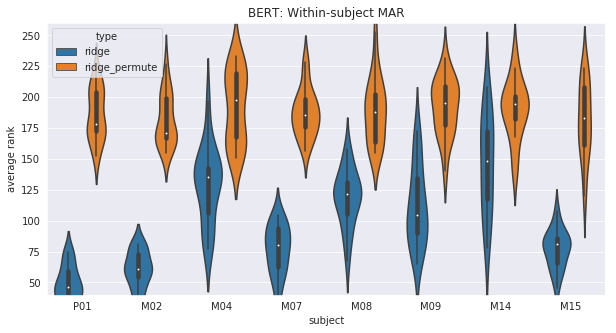

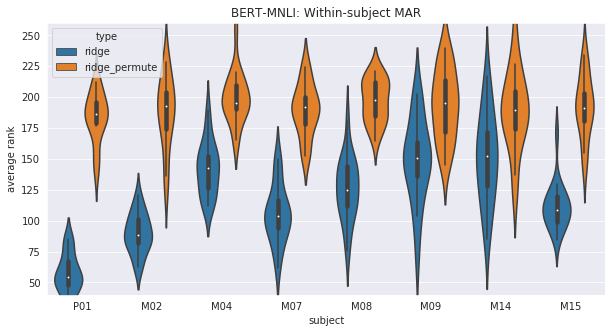

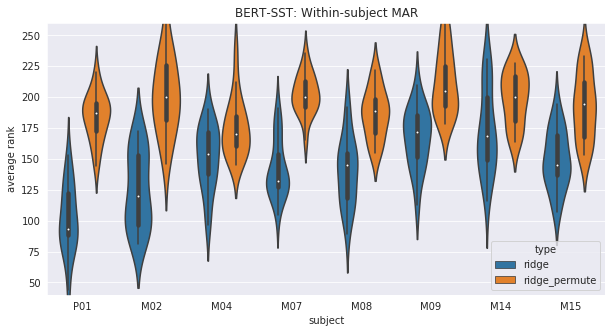

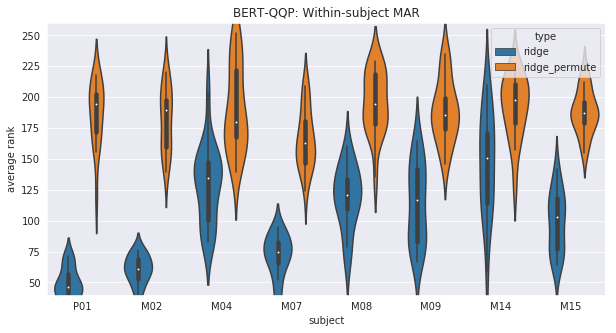

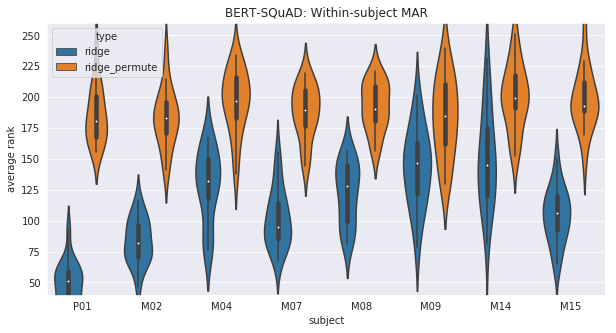

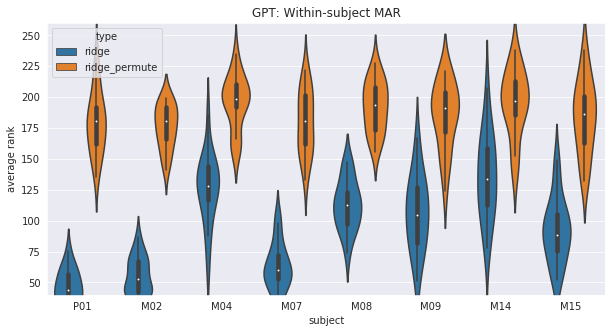

In [28]:
for model, path in models.items():
    f, ax = plt.subplots(figsize=(10,5))
    try:
        stats[model] = util.load_decoding_perf(model, "perf.384sentences.%s.csv" % path, ax=ax)
    except: raise

-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [29]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "metric", "stat"]).reset_index()

In [30]:
f.head()

,target,metric,stat,P01,M02,M04,M07,M08,M09,M14,M15
0,BERT,ridge,mean,48.703704,61.005291,129.359788,76.989418,118.492063,111.478836,146.555556,77.224868
1,BERT,ridge,sem,3.512983,3.432833,7.226109,4.575689,5.369849,7.498580,9.325991,3.653820
2,BERT,ridge_permute,mean,185.690476,181.613757,191.584656,187.447090,189.187831,192.084656,190.251323,181.079365
3,BERT,ridge_permute,sem,4.823489,4.902117,6.917099,4.524329,6.201333,5.375544,5.617909,7.024542
4,BERT-MNLI,ridge,mean,57.653439,89.994709,142.195767,105.584656,125.915344,149.121693,151.087302,111.719577


In [31]:
f = pd.melt(f, id_vars=["target", "metric", "stat"],
            var_name="subject", value_name="value")
f.head()

,target,metric,stat,subject,value
0,BERT,ridge,mean,P01,48.703704
1,BERT,ridge,sem,P01,3.512983
2,BERT,ridge_permute,mean,P01,185.690476
3,BERT,ridge_permute,sem,P01,4.823489
4,BERT-MNLI,ridge,mean,P01,57.653439


In [32]:
wilcoxon_results = util.wilcoxon_rank_preds(models)
wilcoxon_results.head()

8.333333333333333e-05 8


w_stat          p_val  p_val_corrected
model1 model2                                               
BERT   BERT-MNLI   1508554.5   5.473344e-51     4.561120e-53
       BERT-SST    1161078.5  1.626612e-114    1.355510e-116
       BERT-QQP    2015533.0   2.507719e-03     2.089766e-05
       BERT-SQuAD  1666270.5   2.516869e-30     2.097391e-32
       GPT         2023871.0   3.216025e-04     2.680020e-06

In [33]:
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val_corrected"] < 0.01
wilcoxon_results.sort_values("p_val")

,,w_stat,p_val,p_val_corrected,significant_bonferroni
model1,model2,,,,
BERT-SST,GPT,1135531.5,2.262748e-122,1.885623e-124,True
BERT,BERT-SST,1161078.5,1.626612e-114,1.355510e-116,True
BERT-SST,BERT-QQP,1225281.5,2.785005e-100,2.320837e-102,True
BERT-MNLI,GPT,1496551.0,1.205637e-53,1.004697e-55,True
BERT-SST,BERT-SQuAD,1524968.5,1.043920e-51,8.699330e-54,True
BERT,BERT-MNLI,1508554.5,5.473344e-51,4.561120e-53,True
BERT-MNLI,BERT-QQP,1551044.0,1.032279e-43,8.602327e-46,True
BERT-SQuAD,GPT,1600823.5,8.781780e-40,7.318150e-42,True
BERT-MNLI,BERT-SST,1665908.0,1.335938e-35,1.113281e-37,True


---------

# Aggregate graphs

In [34]:
f_mean = f[(f.metric == "ridge") & (f.stat == "mean")].sort_values(["target"])

## Decoding analysis

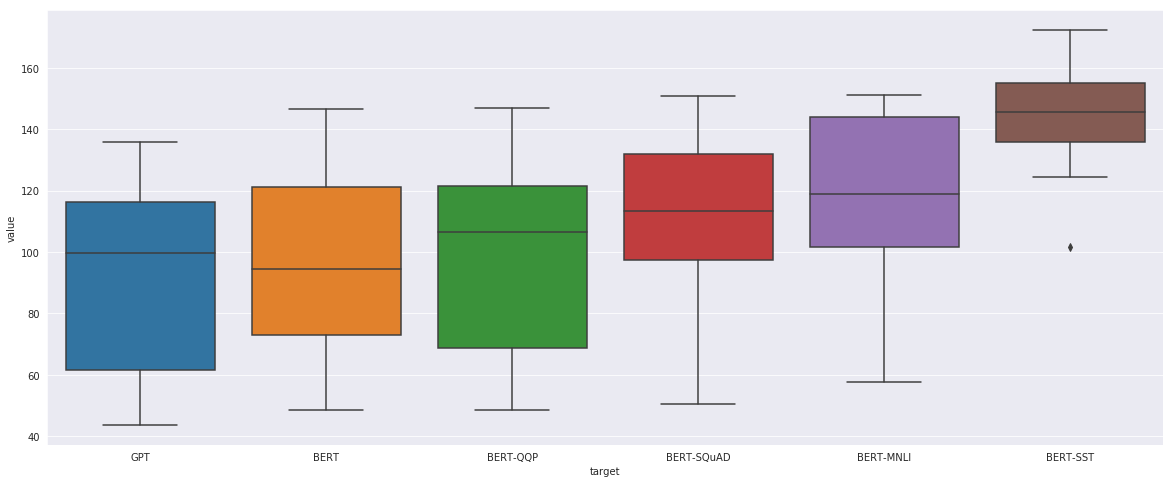

In [35]:
fig, ax = plt.subplots(figsize=(20, 8))
target_order = f_mean.groupby("target").value.mean().argsort()
sns.boxplot(x="target", y="value", data=f_mean,
            ax=ax, order=target_order.index[target_order])

In [36]:
f_mean.groupby("target").mean()

,value
target,
BERT,96.226190
BERT-MNLI,116.659061
BERT-QQP,98.552249
BERT-SQuAD,110.566799
BERT-SST,143.467593
GPT,92.218585


[-0.4  0.6  1.6  2.6  3.6  4.6  0. ]


Text(0.87,-0.07,'* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test')

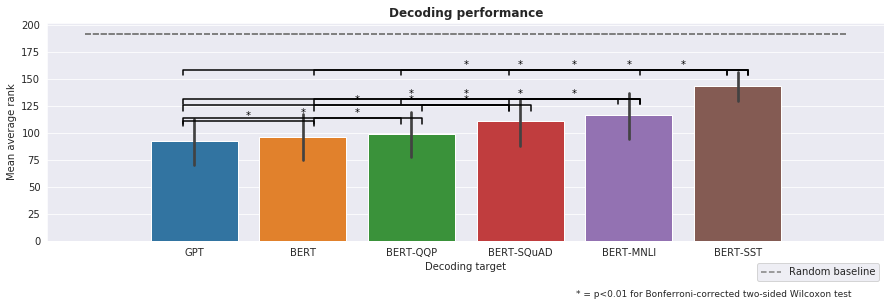

In [37]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x="target", y="value", order=target_order.index[target_order], data=f_mean)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.08))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
xticks = {label.get_text(): (pos, label) for pos, label in xticks}
mean_results = f_mean.groupby("target").value.mean()
for (m1, m2), row in wilcoxon_results.iterrows():
    significant = row.significant_bonferroni
            
    m1_pos, _ = xticks[m1]
    m2_pos, _ = xticks[m2]
    
    if significant:
        y = max(mean_results[m1], mean_results[m2]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.07, "* = p<0.01 for Bonferroni-corrected two-sided Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)

Text(0.5,1,'Decoding performance between subjects')

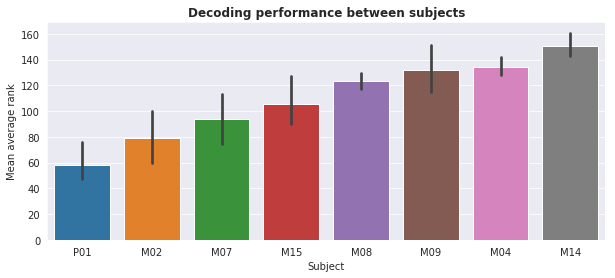

In [38]:
order = f_mean.groupby("subject").value.agg("mean").argsort()
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="subject", y="value", order=order.index[order], data=f_mean, ax=ax)
plt.xlabel("Subject")
plt.ylabel("Mean average rank")
plt.title("Decoding performance between subjects", weight="bold")

In [39]:
n_subjects = len(f_sub.subject.unique())
fig, axs = plt.subplots(n_subjects, 1, figsize=(10, 5 * n_subjects))
for ax, (subj, subj_data) in zip(axs, f[f.metric == "ridge"].groupby("subject")):
    subj_data = subj_data.set_index("stat").sort_index()
    subj_data = pd.pivot_table(subj_data, index=["target"], columns="stat")
    subj_data.columns = subj_data.columns.get_level_values(1)
    order = subj_data["mean"].argsort()
    sns.barplot(x="target", y="mean", data=subj_data.reset_index(), hue="target", order=order.index[order], ax=ax)
    ax.set_title(subj)
    
    # TODO plot yerr

NameError: name 'f_sub' is not defined